In [ ]:

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

In [ ]:

# 读取特征
data = pd.read_csv('datas_FinBERT.csv')
# 首先将日期转换为 datetime 类型，并设置为索引
data['times'] = pd.to_datetime(data['times'])
data.set_index('times', inplace=True)

# 读取标签
monthly_labels = pd.read_csv("./monthly_merged_label.csv")
# 确保日期列为 datetime 类型
monthly_labels['observation_date'] = pd.to_datetime(monthly_labels['observation_date'])
# 将 Employment_Level 的日期列设置为索引
monthly_labels.set_index('observation_date', inplace=True)

In [ ]:

data['sentiment_scores'] = data['sentiment_scores'].apply(ast.literal_eval)

# 计算日统计量
data['mean'] = data['sentiment_scores'].apply(lambda x: sum(x) / len(x) if x else float('nan'))
# data['median'] = data['sentiment_scores'].apply(lambda x: pd.Series(x).median())
# data['max'] = data['sentiment_scores'].apply(lambda x: max(x) if x else float('nan'))
# data['min'] = data['sentiment_scores'].apply(lambda x: min(x) if x else float('nan'))
# data['std'] = data['sentiment_scores'].apply(lambda x: pd.Series(x).std())

In [ ]:

# 创建一个包含所有日期的DataFrame
all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
all_dates_df = pd.DataFrame(index=all_dates)

# 合并数据，补全缺失的日期
data = all_dates_df.join(data, how='left')
data.drop(columns=['Unnamed: 0'], inplace=True)
# 使用0填充缺失值
data = data.fillna(0)
# 显示填充后的数据
print("Filled data:")
print(data.head())

In [ ]:
# 计算滑动统计值
window_size = 7
data['rolling_mean'] = data['mean'].rolling(window=window_size).mean()
data['rolling_std'] = data['mean'].rolling(window=window_size).std()
# 计算变化率（相对于前一天）
# data['change_rate'] = data['mean'].pct_change()
# # 计算加权滑动平均（这里简单地使用线性加权）
# weights = [i for i in range(1, window_size + 1)]
# data['weighted_rolling_mean'] = data['mean'].rolling(window=window_size).apply(lambda x: np.dot(x, weights) / sum(weights), raw=True)
# # 计算指数加权移动平均
# data['exp_rolling_mean'] = data['mean'].ewm(span=window_size, adjust=False).mean()
# 显示前几行以检查结果
data.head(10)

In [ ]:
import numpy as np

# 将所有NaN和inf值替换为0
data = data.replace([np.nan, np.inf, -np.inf], 0)
data.head(10)

In [ ]:

from pandas.tseries.offsets import MonthEnd
#  确定时间范围
start_date = data.index.min() # 第一个月（2006-10）因为没有1号的数据，正好取不到标签里2006-10月的标签
end_date = data.index.max()  + MonthEnd(1) # 用过去预测未来，所以需要多搞一个月的标签
print(start_date,end_date)
# 筛选对应时间范围内的标签
filtered_labels = monthly_labels.loc[start_date:end_date]
filtered_labels.describe

In [ ]:
filtered_labels = filtered_labels['INDPRO']
filtered_labels.shape # = (65,)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 创建一个最小-最大缩放器
scaler = MinMaxScaler()

# 使用最小-最大缩放器进行标签缩放
filtered_labels_scaled = scaler.fit_transform(filtered_labels.values.reshape(-1, 1))
filtered_labels_scaled[:5]

In [51]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 准备输入数据
input_data = []

for month, group in data.groupby(pd.Grouper(freq='M')):
    # monthly_feature = group[['mean', 'median', 'max', 'min', 'std', 'rolling_mean', 'rolling_std', 'change_rate']].values
    monthly_feature = group[['mean','rolling_mean', 'rolling_std']].values
    input_data.append(monthly_feature)

# 使用 pad_sequences 进行填充以确保每个月的数据长度相同
input_data_padded = pad_sequences(input_data, padding='post', dtype='float32')

# 检查填充后的数据形状
print(input_data_padded.shape)

(65, 31, 3)


In [ ]:
def model_evaluation(model,model_name,X_combined,y_combined):
    # 使用某个模型进行预测,nn_model,rf_model,lr_model
    predicted = model.predict(X_combined)
    # 将预测结果转换为一维数组方便绘图
    predicted = predicted.ravel()
    # 绘制真实值和预测值
    plt.figure(figsize=(10,6))
    plt.plot(y_combined, label='Actual',marker='o', linestyle='-')
    plt.plot(predicted, label='Predicted', marker='x', linestyle='-')
    plt.title(f"{model_name} Prediction vs Actual")
    plt.xlabel("Observations")
    plt.ylabel("Target")
    plt.legend()
    plt.show()

def plt_history(history):
    # 绘制训练损失和验证损失
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Training Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Input,LSTM, Dense, Masking,BatchNormalization
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense,Conv2D,MaxPooling2D

1/1 [==============================] - 0s 278ms/step


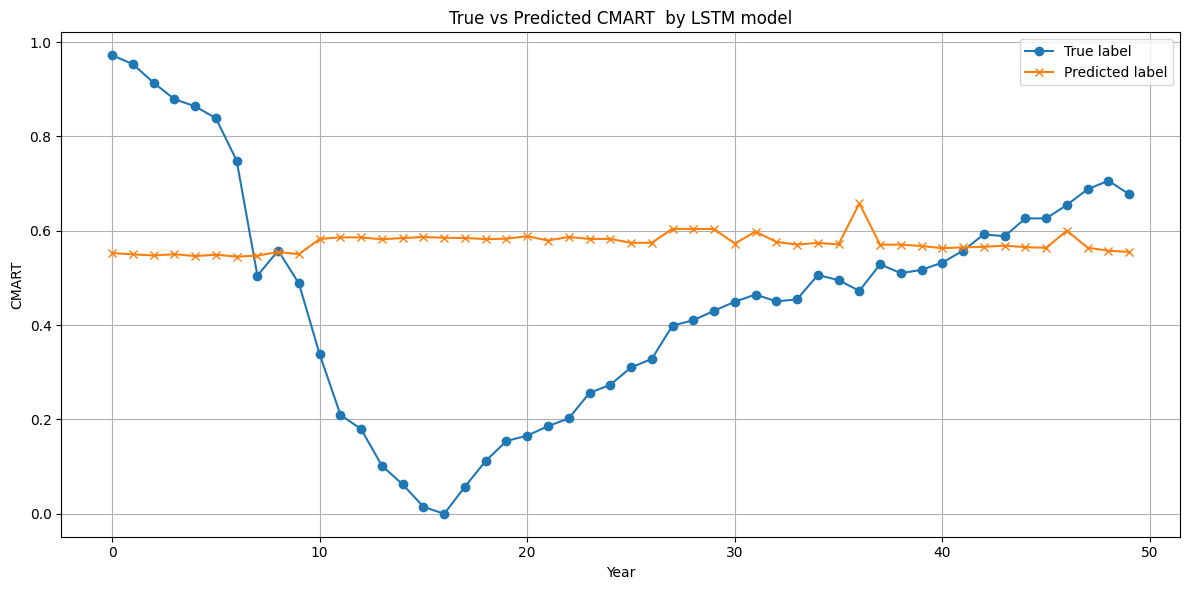

In [76]:
# 定义时间序列交叉验证 * LSTM
tscv = TimeSeriesSplit(n_splits=10) 

# 存储每次预测的真实值和预测值
true_values = []
predictions = []

# 分割数据
for train_index, test_index in tscv.split(input_data_padded):
    X_train, X_test = input_data_padded[train_index], input_data_padded[test_index]
    y_train, y_test = filtered_labels_scaled[train_index], filtered_labels_scaled[test_index]
    # LSTM模型
    lstm_model = Sequential([
        Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),  # 添加掩码层
        LSTM(40, activation='relu'),  # LSTM层，50个单元
        BatchNormalization(),  # 添加批量归一化层
        Dense(1,activation='sigmoid')  # 输出层，单个输出值
    ])

    # # 设置自定义学习率
    # learning_rate = 0.0001 
    # # 创建优化器实例，设置学习率
    # optimizer = Adam(learning_rate=learning_rate)
    # 编译模型，使用自定义优化器
    lstm_model.compile(optimizer='adam', loss='mse')

    # 训练模型
    history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2,verbose=0)
    # 评估模型
    loss = lstm_model.evaluate(X_test, y_test)
    y_pred = lstm_model.predict(X_test)
    # 将预测值和真实值存储起来
    predictions.extend(y_pred)
    true_values.extend(y_test)
    
# for i in range(len(predictions)):
#     if predictions[i] < 0:
#         predictions[i] = 0
plt.figure(figsize=(12, 6))
years = range(len(predictions))  # 确保年份范围正确
# 绘制真实严重性
plt.plot(years, true_values, label='True label', marker='o', linestyle='-')
# 绘制预测严重性
plt.plot(years, predictions, label='Predicted label', marker='x', linestyle='-')
plt.xlabel('Year')
plt.ylabel('CMART')
plt.title('True vs Predicted CMART  by LSTM model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/20
4/4 [==============================] - 2s 70ms/step - loss: 8866.9414 - val_loss: 9060.5312
Epoch 2/20
4/4 [==============================] - 0s 15ms/step - loss: 8857.7910 - val_loss: 9055.0098
Epoch 3/20
4/4 [==============================] - 0s 18ms/step - loss: 8851.5098 - val_loss: 9049.6650
Epoch 4/20
4/4 [==============================] - 0s 16ms/step - loss: 8845.2520 - val_loss: 9043.4854
Epoch 5/20
4/4 [==============================] - 0s 16ms/step - loss: 8838.7168 - val_loss: 9038.2852
Epoch 6/20
4/4 [==============================] - 0s 16ms/step - loss: 8832.6631 - val_loss: 9033.5107
Epoch 7/20
4/4 [==============================] - 0s 16ms/step - loss: 8827.2852 - val_loss: 9030.0664
Epoch 8/20
4/4 [==============================] - 0s 16ms/step - loss: 8821.4941 - val_loss: 9026.3457
Epoch 9/20
4/4 [==============================] - 0s 16ms/step - loss: 8819.8818 - val_loss: 9022.1699
Epoch 10/20
4/4 [==============================] - 0s 15ms/step - loss: 8

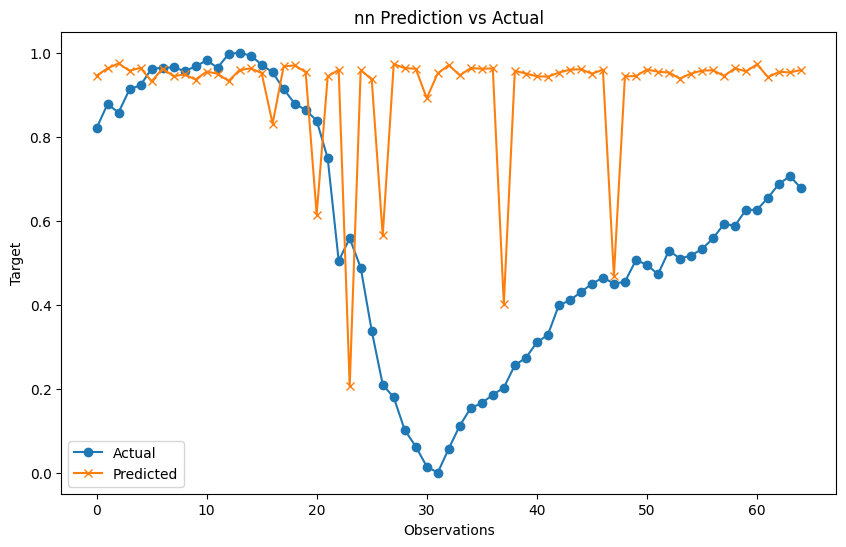

In [77]:
# Dense model with 留出验证
# Flatten the input data
input_data_flattened = input_data_padded.reshape((input_data_padded.shape[0], -1))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(input_data_flattened, filtered_labels, test_size=0.2, random_state=42)
# Build a simple fully connected neural network
nn_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1],)),  # 添加掩码层
    Dense(128, activation='relu'),  # Hidden layer with 64 units and ReLU activation
    BatchNormalization(),  # 添加批量归一化层
    Dense(32),
    Dense(1,activation='sigmoid')  # Output layer
])

# Compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = nn_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

model_evaluation(nn_model, "nn", input_data_flattened, filtered_labels_scaled)

In [78]:
from sklearn.model_selection import train_test_split

# 划分数据集为训练集和测试集,留出验证
X_train, X_test, y_train, y_test = train_test_split(input_data_padded.reshape(input_data_padded.shape[0],input_data_padded.shape[1],input_data_padded.shape[2],1), filtered_labels_scaled, test_size=0.2, random_state=42)

In [79]:
X_train.shape

(52, 31, 3, 1)

In [80]:

# 创建序贯模型
cnn_model = Sequential()
# 添加一维卷积层，设置卷积核大小为 (7, 1)，表示在不同时间点上进行卷积
cnn_model.add(Conv2D(filters=32, kernel_size=(31,1), activation='relu', input_shape=(31, 3, 1)))
# 添加池化层，可以选择最大池化或平均池化
cnn_model.add(MaxPooling2D(pool_size=2))
# 展平层
cnn_model.add(Flatten())
# 添加全连接层
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(1, activation='linear'))  # 线性激活函数用于回归问题
# 编译模型
cnn_model.compile(optimizer='adam', loss='mean_squared_error')  # 使用均方误差作为损失函数

# 训练模型
history = cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# 查看训练过程中的损失变化
import matplotlib.pyplot as plt

# 绘制训练损失和验证损失的曲线
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



ValueError: Exception encountered when calling layer "max_pooling2d" (type MaxPooling2D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,3,32].

Call arguments received by layer "max_pooling2d" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 1, 3, 32), dtype=float32)

In [ ]:
# LSTM模型
lstm_model = Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),  # 添加掩码层
    LSTM(30, activation='relu'),  # LSTM层，50个单元
    # Dense(10,activation='relu'),
    Dense(1,activation='sigmoid')  # 输出层，单个输出值
])
# 编译模型，使用自定义优化器
lstm_model.compile(optimizer='adam', loss='mse')
# 指定训练时期数和批处理大小
epochs = 20
batch_size = 8
# 训练模型
history = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
# 评估模型
loss = lstm_model.evaluate(X_test, y_test)
# 打印损失值
print("Test Loss:", loss)
model_evaluation(lstm_model, "LSTM", input_data_padded, filtered_labels_scaled)